<a href="https://colab.research.google.com/github/PauDK/Deceptive-Review-Detection/blob/main/BERT_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-text
!pip install tf-models-official

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from pprint import pprint

In [3]:
print(tf.__version__)

2.8.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/Chicago_Hotel_Reviews.csv", index_col=0)
df = df.drop('Rating', axis=1)
df.loc[df['Label'] == -1, 'Label'] = 0
X = df['Ori_Review']
y = df['Label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [8]:
text_inputs = [keras.layers.Input(shape=(), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

seq_length = 512  # Set sequence length
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))
preprocessed_text = bert_pack_inputs(tokenized_inputs)

{'boxes': [<matplotlib.lines.Line2D at 0x7f9b9ee91290>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9b9ef2b050>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9b9edd09d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9b9eebc350>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9b9ee91b90>,
  <matplotlib.lines.Line2D at 0x7f9b9ef2b2d0>]}

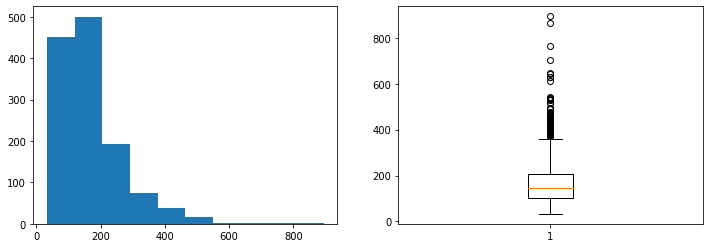

In [9]:
sizes = []
tokens = tokenize(X_train)
for i in range(tokens.shape[0]):
  sizes.append(tokens[i].shape[0])

from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.hist(sizes)
ax2.boxplot(sizes)

In [10]:
text_inputs

[<KerasTensor: shape=(None,) dtype=string (created by layer 'input_1')>]

In [11]:
preprocessed_text

{'input_mask': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>,
 'input_type_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>,
 'input_word_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>}

In [12]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

In [13]:
# Train all BERT layers as suggested by BERT developers
bert_encoder.trainable = True

# Bert layers
outputs = bert_encoder(preprocessed_text)

# Dense layers
l = keras.layers.Dense(1, activation='sigmoid', name="output") (outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = keras.Model(inputs=text_inputs, outputs = [l])

In [14]:
epochs = 3
batch_size = 8
init_lr = 3e-5  # best of [5e-5, 3e-5, 2e-5]

train_data_size = X_train.shape[0]
steps_per_epoch = train_data_size // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

test_data_size = X_test.shape[0]

In [15]:
optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics='accuracy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['keras_layer[0][0]']            
                                (None, 512),                                                      
                                 'input_mask': (Non                                               
                                e, 512),                                                      

In [16]:
bert_encoder.trainable = False
model.fit(X_train,
          y_train,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=(X_test, y_test))

Epoch 1/3
160/160 [==============================] - 370s 2s/step - loss: 0.4740 - accuracy: 0.7539 - val_loss: 0.4421 - val_accuracy: 0.8188
Epoch 2/3
160/160 [==============================] - 333s 2s/step - loss: 0.2459 - accuracy: 0.9219 - val_loss: 0.2851 - val_accuracy: 0.9125
Epoch 3/3
160/160 [==============================] - 337s 2s/step - loss: 0.0920 - accuracy: 0.9758 - val_loss: 0.3644 - val_accuracy: 0.9219


In [41]:
prediction = model.predict(X_test)
prediction_real = model.predict(X_test[y_test == 0])
prediction_fake = model.predict(X_test[y_test == 1])

In [51]:
prediction_bi_real = prediction_real.copy()
prediction_bi_real[np.where(prediction_real <= 0.5)] = 0
prediction_bi_real[np.where(prediction_real > 0.5)] = 1
print('True Positive Rate:', '{:.2%}'.format(1 - sum(prediction_bi_real)[0] / len(prediction_bi_real)))

prediction_bi_fake = prediction_fake.copy()
prediction_bi_fake[np.where(prediction_fake <= 0.5)] = 0
prediction_bi_fake[np.where(prediction_fake > 0.5)] = 1
print('False Positive Rate:', '{:.2%}'.format(sum(prediction_bi_fake)[0] / len(prediction_bi_fake)))

True Positive Rate: 90.91%
False Positive Rate: 93.55%


In [66]:
demo_ind = np.random.choice(X_test.index)
realfake = 'Real' if y_test[demo_ind] == 0 else 'Fake'
prediction = model.predict([X_test[demo_ind]])
prediction_rf = 'Real' if prediction <= 0.5 else 'Fake'

print(f'{realfake} review to be fed to model:\n', X_test[demo_ind], '\n')
print(f'Model prediction: {prediction_rf}')

Fake review to be fed to model:
 The Knickerbocker hotel was one of my favorite hotels to visit. My wife and I utilized the park & play package, which gave us an amazing room, complimentary valet service, and a great kit to plan our weekend around. It was well worth the price and we both wish to go back again. The rooms were top notch and the hotel's staff was excellent. One of the employees, Craig, helped us find our way around the city and this shows the Knickerbocker really cares about its guests. We loved our visit and are sure you will too. A+ 

Model prediction: Fake


In [ ]:
!pwd

/content


In [ ]:
import os

main_save_path = '/content/drive/My Drive/Colab Notebooks/my_models'
saved_model_name = 'Fine_Tune_Bert_Accu_92-19'
saved_model_path = os.path.join(main_save_path, saved_model_name)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

model.save(saved_model_path, include_optimizer=False, options=save_options)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/my_models/Fine_Tune_Bert_Accu_92-19/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/my_models/Fine_Tune_Bert_Accu_92-19/assets
